<a href="https://colab.research.google.com/github/TheAmirHK/Experiments/blob/main/GameTheory/EvolutionaryPrisoner%E2%80%99sDilemma(EPD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

One of my personal favorite games :)

The **Evolutionary Prisoner's Dilemma (EPD)** extends the classic Prisoner's Dilemma by incorporating evolutionary dynamics, where strategies compete and evolve in a population over repeated interactions. It explores how cooperative behaviors can emerge and persist despite the temptation to defect, using principles from game theory and evolutionary biology. For more referx to Fudenberg D, Nowak MA, Taylor C, Imhof LA. Evolutionary game dynamics in finite populations with strong selection and weak mutation. Theoretical Population Biology. 2006;70(3):352–363. doi: 10.1016/j.tpb.2006.07.006.

In [43]:
import random
import numpy as np
import matplotlib.pyplot as plt

I used ChatGPT helping me writing this !


## **1. Game Basics**  
Each round, two players interact and choose between:  
- **Cooperate (C)**
- **Defect (D)**

The payoffs are defined by the **Prisoner’s Dilemma Payoff Matrix**:

$$
\begin{bmatrix}
(R, R) & (S, T) \\
(T, S) & (P, P)
\end{bmatrix}
$$

Where:  
- **Reward (R)**: If both cooperate → \( R = 3 \)  
- **Temptation (T)**: If one defects, the defector gets \( T = 5 \)  
- **Sucker (S)**: If one cooperates while the other defects → \( S = 0 \)  
- **Punishment (P)**: If both defect → \( P = 1 \)  

The game satisfies the condition:

$$
T > R > P > S
$$


---

## **2. Memory and Strategy Representation**  
Each player has:  
- **Memory Length $ m $** → Number of past rounds considered.  
- **Strategy $ s $** → Determines a player's move based on past interactions.  

A player’s decision function is:

$$
a_t = f(h_{t-m}, h_{t-m+1}, ..., h_{t-1})
$$

where **$ h_t $** is the history of past moves, and **$a_t $** is the action in round $ t $.  

---

## **3. Evolutionary Dynamics**  

### **Selection Process**  
At each generation, players are ranked by their total **score (fitness)**:

$$
F_i = \sum_{t=1}^{T} \pi_i(t)
$$

where **$ \pi_i(t) $** is the payoff earned by player $ i $ in round $ t $.  

The **top-performing** strategies survive, while weaker strategies are replaced.  

### **Mutation Process**  
To introduce variation, new strategies undergo mutation:

1. **Strategy Mutation:**  
   - A player **randomly changes their strategy** with probability $ p_s $.  
   - The new strategy is chosen from a predefined set.  

2. **Memory Mutation:**  
   - A player's memory size **randomly increases or decreases** with probability $ p_m $.  

Mathematically:

$$
s_i' = \text{Mutate}(s_i) \quad \text{with probability } p_s
$$

$$
m_i' = m_i + \text{rand}(-1,1) \quad \text{with probability } p_m
$$

---

## **4. Population Dynamics**  
At each generation:  
1. **Players play multiple rounds** and accumulate scores.  
2. The **top 50%** of players **survive** and reproduce.  
3. New players **inherit** strategies but may **mutate**.  
4. The next generation competes, repeating the cycle.  

The population evolution follows:

$$
S_{t+1} = f(S_t, \pi_t, \mu)
$$

where **$ S_t $** is the set of strategies at time $t$, **$ \pi_t $** is the payoff distribution, and **$ \mu $** is the mutation operator.  

---

## **5. Stability and Equilibrium**  
Over time, the model converges to a mix of:  
- **Tit-for-Tat (TFT):** Reciprocates cooperation.  
- **Pavlov:** Learns from past successes.  
- **Grim Trigger:** Harshly punishes defection.  

The proportion of each strategy follows the **replicator equation**:

$$
\frac{dx_i}{dt} = x_i \left( f_i - \bar{f} \right)
$$

where $ x_i$ is the fraction of strategy $i$, $f_i$ is its fitness, and $ \bar{f}$ is the average population fitness.  



In [44]:
COOPERATE = "C"
DEFECT = "D"

PAYOFF_MATRIX = {
    (COOPERATE, COOPERATE): (3, 3),
    (COOPERATE, DEFECT): (0, 5),
    (DEFECT, COOPERATE): (5, 0),
    (DEFECT, DEFECT): (1, 1)
}

This simulation includes five strategies:

1. Tit-for-Tat : Starts with C, then copies the opponent’s last move.
2. Grim Trigger : Starts with C, but defects forever if the opponent defects even once.
3. Pavlov : Repeats last move if it led to a good outcome, switches otherwise.
4. Random : Chooses C or D randomly.
5. Memory-Weighted : Analyzes past behavior and cooperates if opponent cooperated more than 50% of the time.

In [45]:
STRATEGIES = ["Tit-for-Tat", "Grim Trigger", "Pavlov", "Random", "Memory-Weighted"]

In [46]:
class Player:

    def __init__(self, strategy=None, memory_size=5, decay_factor=0.9):
        self.strategy = strategy if strategy else random.choice(STRATEGIES)
        self.memory_size = memory_size if memory_size else random.randint(1, 10)
        self.decay_factor = decay_factor
        self.history = {}
        self.score = 0

    def get_opponent_history(self, opponent_name):
        return self.history.get(opponent_name, [])[-self.memory_size:]

    def update_history(self, opponent_name, opponent_action):
        if opponent_name not in self.history:
            self.history[opponent_name] = []
        self.history[opponent_name].append(opponent_action)

    def choose_action(self, opponent_name):
        history = self.get_opponent_history(opponent_name)

        if self.strategy == "Tit-for-Tat":
            return history[-1] if history else COOPERATE

        elif self.strategy == "Grim Trigger":
            return DEFECT if DEFECT in history else COOPERATE

        elif self.strategy == "Pavlov":
            if len(history) < 2:
                return COOPERATE
            return history[-1] if history[-1] == history[-2] else DEFECT

        elif self.strategy == "Random":
            return random.choice([COOPERATE, DEFECT])

        elif self.strategy == "Memory-Weighted":
            if not history:
                return COOPERATE
            coop_rate = sum(1 if h == COOPERATE else 0 for h in history) / len(history)
            return COOPERATE if coop_rate > 0.5 else DEFECT

        return COOPERATE

    def mutate(self, mutation_rate=0.1):
        if random.random() < mutation_rate:
            self.strategy = random.choice(STRATEGIES)
        if random.random() < mutation_rate:
            self.memory_size = max(1, min(10, self.memory_size + random.choice([-1, 1])))

In [47]:
POPULATION_SIZE = 20
GENERATIONS = 200
ROUNDS_PER_MATCH = 10
MUTATION_RATE = 0.1

strategy_counts = {strategy: [] for strategy in STRATEGIES}
memory_sizes = []

population = [Player() for _ in range(POPULATION_SIZE)]

In [48]:
for generation in range(GENERATIONS):
    print(f"=== Generation {generation+1} ===")

    for player in population:
        player.score = 0

    for i, player_A in enumerate(population):
        for j, player_B in enumerate(population):
            if i >= j:
                continue

            for _ in range(ROUNDS_PER_MATCH):
                action_A = player_A.choose_action(player_B.strategy)
                action_B = player_B.choose_action(player_A.strategy)

                player_A.update_history(player_B.strategy, action_B)
                player_B.update_history(player_A.strategy, action_A)

                score_A, score_B = PAYOFF_MATRIX[(action_A, action_B)]
                player_A.score += score_A
                player_B.score += score_B

    strategy_distribution = {strategy: 0 for strategy in STRATEGIES}
    for player in population:
        strategy_distribution[player.strategy] += 1
    for strategy in STRATEGIES:
        strategy_counts[strategy].append(strategy_distribution[strategy])

    avg_memory_size = np.mean([player.memory_size for player in population])
    memory_sizes.append(avg_memory_size)

    population.sort(key=lambda p: p.score, reverse=True)

    print("\nTop Performers:")
    for i in range(3):
        print(f"{population[i].strategy} (Memory: {population[i].memory_size}): {population[i].score} points")


    num_survivors = POPULATION_SIZE // 2     # Evolution: Here I just keep top 50% and replace the rest with mutated versions
    new_population = population[:num_survivors]

    for _ in range(POPULATION_SIZE - num_survivors):
        parent = random.choice(new_population)
        offspring = Player(strategy=parent.strategy, memory_size=parent.memory_size)
        offspring.mutate(MUTATION_RATE)
        new_population.append(offspring)

    population = new_population

=== Generation 1 ===

Top Performers:
Pavlov (Memory: 5): 574 points
Pavlov (Memory: 5): 561 points
Pavlov (Memory: 5): 559 points
=== Generation 2 ===

Top Performers:
Pavlov (Memory: 5): 570 points
Pavlov (Memory: 5): 570 points
Pavlov (Memory: 5): 570 points
=== Generation 3 ===

Top Performers:
Pavlov (Memory: 5): 568 points
Pavlov (Memory: 5): 568 points
Memory-Weighted (Memory: 5): 567 points
=== Generation 4 ===

Top Performers:
Pavlov (Memory: 5): 570 points
Pavlov (Memory: 5): 570 points
Memory-Weighted (Memory: 5): 570 points
=== Generation 5 ===

Top Performers:
Pavlov (Memory: 5): 570 points
Pavlov (Memory: 5): 570 points
Memory-Weighted (Memory: 5): 570 points
=== Generation 6 ===

Top Performers:
Pavlov (Memory: 5): 570 points
Pavlov (Memory: 5): 570 points
Memory-Weighted (Memory: 5): 570 points
=== Generation 7 ===

Top Performers:
Pavlov (Memory: 5): 570 points
Pavlov (Memory: 5): 570 points
Memory-Weighted (Memory: 5): 570 points
=== Generation 8 ===

Top Performers:


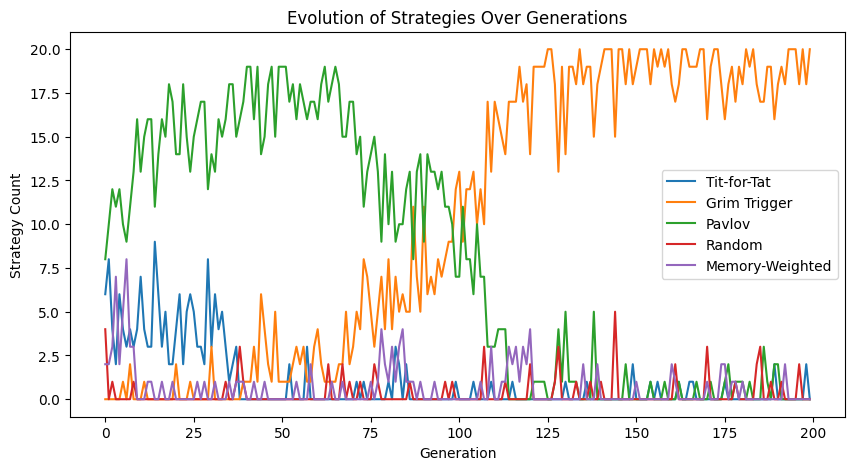

In [49]:
# Plot Strategy Evolution
plt.figure(figsize=(10, 5))
for strategy, counts in strategy_counts.items():
    plt.plot(range(GENERATIONS), counts, label=strategy)
plt.xlabel("Generation")
plt.ylabel("Strategy Count")
plt.title("Evolution of Strategies Over Generations")
plt.legend()
plt.show()